# Imports

In [1]:
import keras
import mdn
from scipy.stats import norm
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Load data

In [2]:
X_train = pd.read_csv('./data/X_train_normal.csv', usecols=['GAME_ID', 'GAME_TIME', 'HT_SCORE_DIFF','HT_POSS'])
X_test_internal = pd.read_csv('./data/X_test_internal_normal.csv', usecols=['GAME_ID', 'GAME_TIME', 'HT_SCORE_DIFF','HT_POSS'])
X_test_external = pd.read_csv('./data/X_test_external_normal.csv', usecols=['GAME_ID', 'GAME_TIME', 'HT_SCORE_DIFF','HT_POSS'])
Y_train = pd.read_csv('./data/Y_train_binary.csv')
Y_test_internal = pd.read_csv('./data/Y_test_internal_binary.csv')
Y_test_external = pd.read_csv('./data/Y_test_external_binary.csv')
train = pd.concat([X_train, Y_train], axis=1)
test_internal = pd.concat([X_test_internal, Y_test_internal], axis=1)
test_external = pd.concat([X_test_external, Y_test_external], axis=1)

# Define custom data generator for sequential data

In [3]:
# Define custom generator class for sequential data
# https://stackoverflow.com/questions/55116638/use-keras-timeseriesgenerator-function-to-generate-squence-group-by-some-id
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(keras.utils.Sequence):
    #'Generates data for Keras'
    def __init__(self, data, length, batch_size=32):
        self.tgs = list()
        unique_game_ids = data['GAME_ID'].unique().tolist()
        for game_id in unique_game_ids:
            game_data = data[data['GAME_ID'] == game_id]
            final_score = game_data['OUTCOME'].values[0]
            # pad length - 1 zero rows to head game df
            zero_pad_game_id_df = pd.DataFrame(data=np.full((length-1, 1), game_id), columns=['GAME_ID'])
            zero_pad_zeros_df = pd.DataFrame(data=np.full((length-1, 3), 0), columns=['GAME_TIME', 'HT_SCORE_DIFF', 'HT_POSS'])
            zero_pad_final_score_df = pd.DataFrame(data=np.full((length-1, 1), final_score), columns=['OUTCOME'])
            zero_df = pd.concat([zero_pad_game_id_df, zero_pad_zeros_df, zero_pad_final_score_df], axis=1, sort=False)
            # pad extra tail row to game df
            game_tail = game_data.tail(1)
            zero_padded_game_data = pd.concat([zero_df, game_data, game_tail], sort=False)
            self.tgs.append(keras.preprocessing.sequence.TimeseriesGenerator(zero_padded_game_data[['GAME_TIME', 'HT_SCORE_DIFF', 'HT_POSS']].values, zero_padded_game_data['OUTCOME'].values, length, batch_size=batch_size))
            
        self.len = sum([len(tg) for tg in self.tgs])
        self.idx_i = list()
        self.idx_j = list()
        
        for i, tg in enumerate(self.tgs):
            self.idx_i.extend(list(range(len(tg))))
            self.idx_j.extend([i] * len(tg))
            
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        return self.tgs[self.idx_j[index]][self.idx_i[index]]

# Create sequential data for model fitting

In [4]:
SEQ_LENGTH = 10
BATCH_SIZE = 32
train_gen = DataGenerator(train, SEQ_LENGTH, BATCH_SIZE)
test_internal_gen = DataGenerator(test_internal, SEQ_LENGTH, BATCH_SIZE)
test_external_gen = DataGenerator(test_external, SEQ_LENGTH, BATCH_SIZE)

In [5]:
print(train_gen[0][0].shape)

(32, 10, 3)


# Define neural network architecture

In [6]:
N_HIDDEN = 4
num_input_features = train_gen[0][0].shape[2]
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(units=N_HIDDEN, input_shape=(SEQ_LENGTH, num_input_features), activation='tanh'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy', 'binary_accuracy'])
model.summary()

W0116 09:44:33.136890 4437173696 deprecation_wrapper.py:119] From /Users/henrypoole/anaconda3/envs/thesis-v2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0116 09:44:33.174298 4437173696 deprecation_wrapper.py:119] From /Users/henrypoole/anaconda3/envs/thesis-v2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0116 09:44:33.177033 4437173696 deprecation_wrapper.py:119] From /Users/henrypoole/anaconda3/envs/thesis-v2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0116 09:44:33.276705 4437173696 deprecation_wrapper.py:119] From /Users/henrypoole/anaconda3/envs/thesis-v2/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 4)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


# Fit model

In [7]:
model_fit = model.fit_generator(generator=train_gen, validation_data=test_internal_gen, epochs=5)

W0116 09:44:33.519195 4437173696 deprecation_wrapper.py:119] From /Users/henrypoole/anaconda3/envs/thesis-v2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/5
64308/64308 [==============================] - 444s 7ms/step - loss: 0.4798 - acc: 0.7533 - binary_accuracy: 0.7533 - val_loss: 0.5041 - val_acc: 0.7401 - val_binary_accuracy: 0.7401
Epoch 2/5
64308/64308 [==============================] - 466s 7ms/step - loss: 0.4726 - acc: 0.7549 - binary_accuracy: 0.7549 - val_loss: 0.5032 - val_acc: 0.7394 - val_binary_accuracy: 0.7394
Epoch 3/5
64308/64308 [==============================] - 466s 7ms/step - loss: 0.4717 - acc: 0.7553 - binary_accuracy: 0.7553 - val_loss: 0.5075 - val_acc: 0.7385 - val_binary_accuracy: 0.7385
Epoch 4/5
64308/64308 [==============================] - 465s 7ms/step - loss: 0.4711 - acc: 0.7556 - binary_accuracy: 0.7556 - val_loss: 0.5047 - val_acc: 0.7364 - val_binary_accuracy: 0.7364
Epoch 5/5
64308/64308 [==============================] - 454s 7ms/step - loss: 0.4706 - acc: 0.7548 - binary_accuracy: 0.7548 - val_loss: 0.5112 - val_acc: 0.7327 - val_binary_accuracy: 0.7327


# Save model

In [8]:
model_json = model.to_json()
with open("base_rnn_seq_length_{}_classification_model.json".format(SEQ_LENGTH), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("base_rnn_seq_length_{}_classification_model.h5".format(SEQ_LENGTH))

# Plot training/validation loss

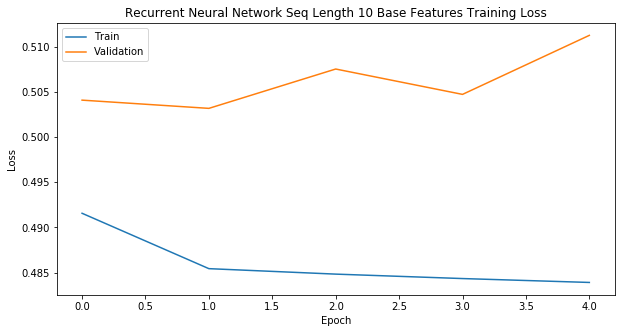

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('Recurrent Neural Network Seq Length {} Base Features Training Loss'.format(SEQ_LENGTH))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Make binary class and probabilistic predictions

In [10]:
# Make probabilistic predictions
Y_train_prob_pred = model.predict_generator(train_gen)[:, 0]
Y_test_internal_prob_pred = model.predict_generator(test_internal_gen)[:, 0]
Y_test_external_prob_pred = model.predict_generator(test_external_gen)[:, 0]

# Convert to binary predictions
Y_train_class_pred = np.where(Y_train_prob_pred <= 0.5, 0, 1)
Y_test_internal_class_pred = np.where(Y_test_internal_prob_pred <= 0.5, 0, 1)
Y_test_external_class_pred = np.where(Y_test_external_prob_pred <= 0.5, 0, 1)

# Save predictions as .csv
Y_train_pred = pd.DataFrame({'class_pred':Y_train_class_pred, 'prob_pred':Y_train_prob_pred})
Y_train_pred.to_csv('./data/base_rnn_seq_length_{}_train_predictions.csv'.format(SEQ_LENGTH), index=False)

Y_test_internal_pred = pd.DataFrame({'class_pred':Y_test_internal_class_pred, 'prob_pred':Y_test_internal_prob_pred})
Y_test_internal_pred.to_csv('./data/base_rnn_seq_length_{}_test_internal_predictions.csv'.format(SEQ_LENGTH), index=False)

Y_test_external_pred = pd.DataFrame({'class_pred':Y_test_external_class_pred, 'prob_pred':Y_test_external_prob_pred})
Y_test_external_pred.to_csv('./data/base_rnn_seq_length_{}_test_external_predictions.csv'.format(SEQ_LENGTH), index=False)

In [11]:
print(Y_train_prob_pred)

[0.6301499  0.651392   0.6494479  ... 0.99441016 0.99440926 0.99440885]


# Evaluate Results

In [12]:
# Classification reports
train_classification_report = classification_report(Y_train, Y_train_class_pred, target_names=['Away Team Win', 'Home Team Win'], digits=4)
test_internal_classification_report = classification_report(Y_test_internal, Y_test_internal_class_pred, target_names=['Away Team Win', 'Home Team Win'], digits=4)
test_external_classification_report = classification_report(Y_test_external, Y_test_external_class_pred, target_names=['Away Team Win', 'Home Team Win'], digits=4)

In [13]:
print(train_classification_report)

               precision    recall  f1-score   support

Away Team Win     0.7562    0.5212    0.6170    779434
Home Team Win     0.7430    0.8917    0.8106   1209790

     accuracy                         0.7465   1989224
    macro avg     0.7496    0.7064    0.7138   1989224
 weighted avg     0.7481    0.7465    0.7347   1989224



In [14]:
print(test_internal_classification_report)

               precision    recall  f1-score   support

Away Team Win     0.7785    0.5297    0.6304     96760
Home Team Win     0.7137    0.8861    0.7906    128011

     accuracy                         0.7327    224771
    macro avg     0.7461    0.7079    0.7105    224771
 weighted avg     0.7416    0.7327    0.7216    224771



In [15]:
print(test_external_classification_report)

               precision    recall  f1-score   support

Away Team Win     0.7722    0.5437    0.6381    104262
Home Team Win     0.6974    0.8677    0.7733    126379

     accuracy                         0.7213    230641
    macro avg     0.7348    0.7057    0.7057    230641
 weighted avg     0.7313    0.7213    0.7122    230641



In [16]:
# Calculate log loss
train_log_loss = log_loss(Y_train, Y_train_prob_pred)
test_internal_log_loss = log_loss(Y_test_internal, Y_test_internal_prob_pred)
test_external_log_loss = log_loss(Y_test_external, Y_test_external_prob_pred)

In [17]:
print(train_log_loss)

0.4851099351043177


In [18]:
print(test_internal_log_loss)

0.5112345931961478


In [19]:
print(test_external_log_loss)

0.5138901758207133


In [20]:
# Calculate area under ROC curve

def plot_roc_curve(true, pred, title):
    fpr, tpr, threshold = roc_curve(true, pred)
    roc_auc = auc(fpr, tpr)
    plt.title('{} ROC Curve'.format(title))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

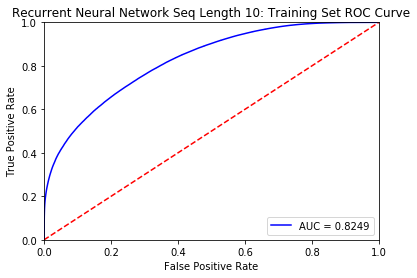

In [21]:
plot_roc_curve(Y_train, Y_train_prob_pred, 'Recurrent Neural Network Seq Length {}: Training Set'.format(SEQ_LENGTH))

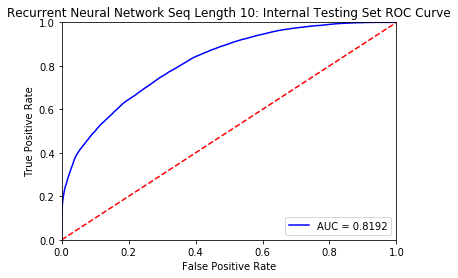

In [22]:
plot_roc_curve(Y_test_internal, Y_test_internal_prob_pred, 'Recurrent Neural Network Seq Length {}: Internal Testing Set'.format(SEQ_LENGTH))

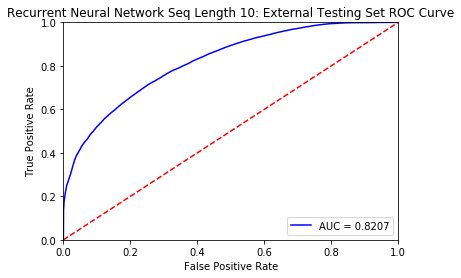

In [23]:
plot_roc_curve(Y_test_external, Y_test_external_prob_pred, 'Recurrent Neural Network Seq Length {}: External Testing Set'.format(SEQ_LENGTH))